# Установка библиотек

In [ ]:
pip install sktime

In [ ]:
# Загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric = True)

# Загрузка и работа с индексами

In [ ]:
# Загрузка дата-сета

df = pd.read_csv("daily-min-temperatures.csv")
df.head(5)

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [ ]:
# Преобразуем дату к стандартнму виду
df.Date = pd.to_datetime(df.Date)
# Переносим преобразованную дату в индекс
df.set_index("Date", inplace = True)
df.head(5)

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


# Начальная визуализация

In [ ]:
df.head(5)

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


<Axes: xlabel='Date', ylabel='Temp'>

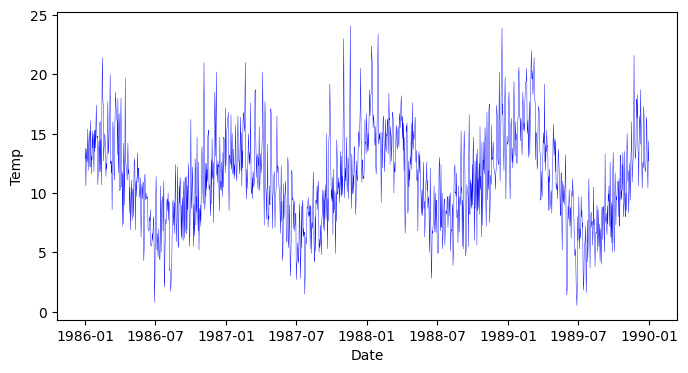

In [ ]:
# Визуализируем временной ряд за 1986-1989 годы
df_86_89 = df.loc["1986":"1989"]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 4))
sns.lineplot(data = df_86_89, x = df_86_89.index, y = "Temp", color = "b", linewidth = 0.3)

С помощью скользящего среднего выделим компоненты временного ряда

'Таким образом месячный график показывает сезонность колебания среднесуточной температуры, квартальный график - цикличность, а годовой график - тренд '

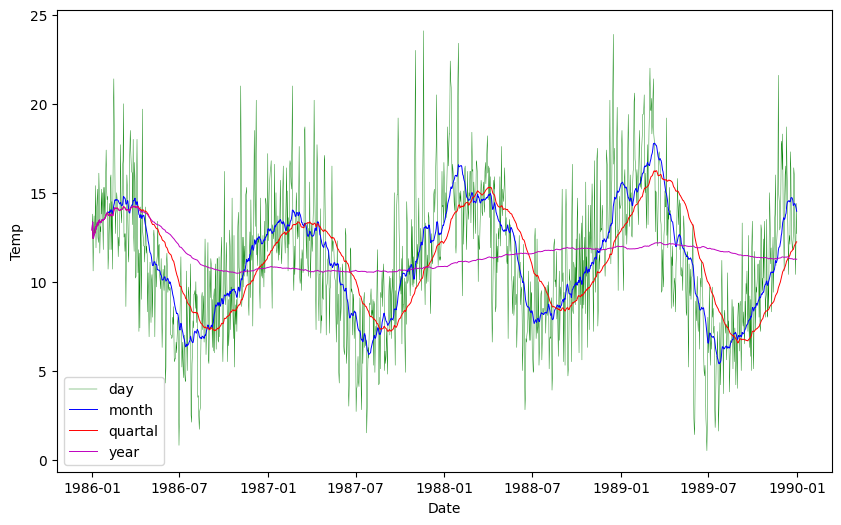

In [ ]:
df_rol_d = df_86_89[['Temp']].rolling('1d').mean()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 6))
sns.lineplot(data = df_rol_d, x = "Date", y = "Temp", color = "g", linewidth = 0.3, label = "day")

df_rol_m = df_86_89[['Temp']].rolling('31d').mean()
sns.lineplot(data = df_rol_m, x = "Date", y = "Temp", color = "b", linewidth = 0.7, label = "month")

df_rol_q = df_86_89[['Temp']].rolling('93d').mean()
sns.lineplot(data = df_rol_q, x = "Date", y = "Temp", color = "r", linewidth = 0.7, label = "quartal")

df_rol_y = df_86_89[['Temp']].rolling('365d').mean()
sns.lineplot(data = df_rol_y, x = "Date", y = "Temp", color = "m", linewidth = 0.7, label = "year")

"""Таким образом месячный график показывает сезонность колебания среднесуточной температуры, квартальный график - цикличность, а годовой график - тренд """

# Базовые методы предсказания

Делим данные на тренировочный и тестовые

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Temp'>)

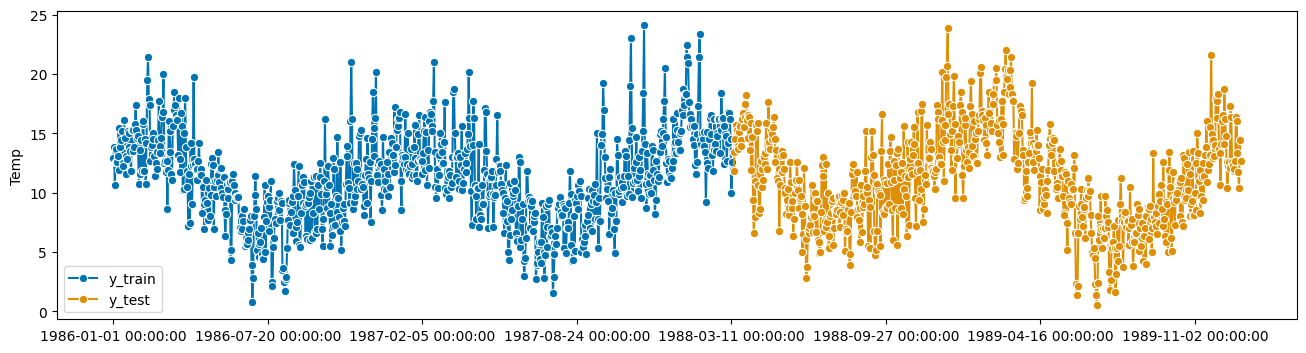

In [ ]:
T_s = int(0.45 * df_86_89.Temp.size)
y_train, y_test = temporal_train_test_split(df_86_89.Temp, test_size = T_s)
sktime.utils.plotting.plot_series(y_train, y_test, labels = ["y_train", "y_test"], markers = None)

Используем NaiveForcaster с различными аргументами

NaiveForcaster, s = last

sMAPE = 0.309


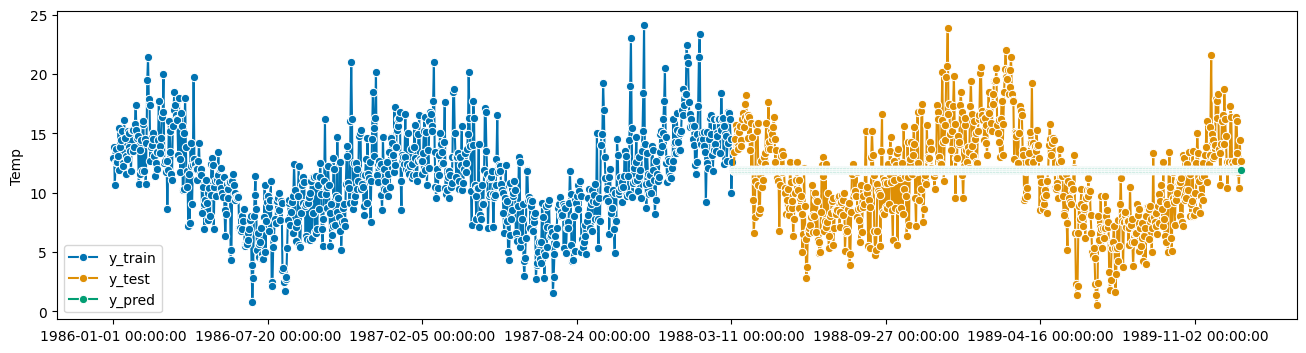

In [ ]:
# ГОРИЗОНТ
fh = ForecastingHorizon(y_test.index, is_relative=False)

# ПРЕДСКАЗАТЕЛЬ
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# ОШИБКА
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

NaiveForcaster, s = drift

sMAPE = 0.256


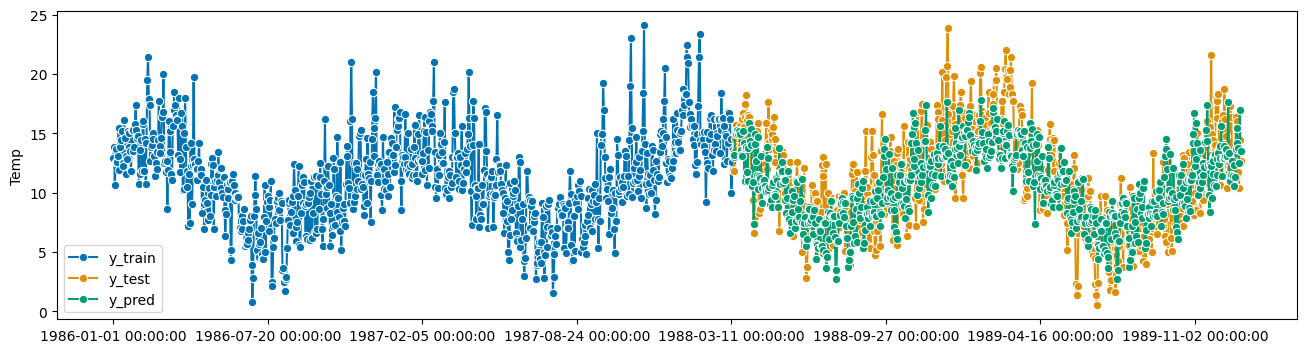

In [ ]:
SEASON = 365

forecaster = NaiveForecaster(strategy="mean", sp=365)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Используем ExponentialSmoothing (Экспоненциальное сглаживание) с различными аргументами

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


sMAPE = 0.314


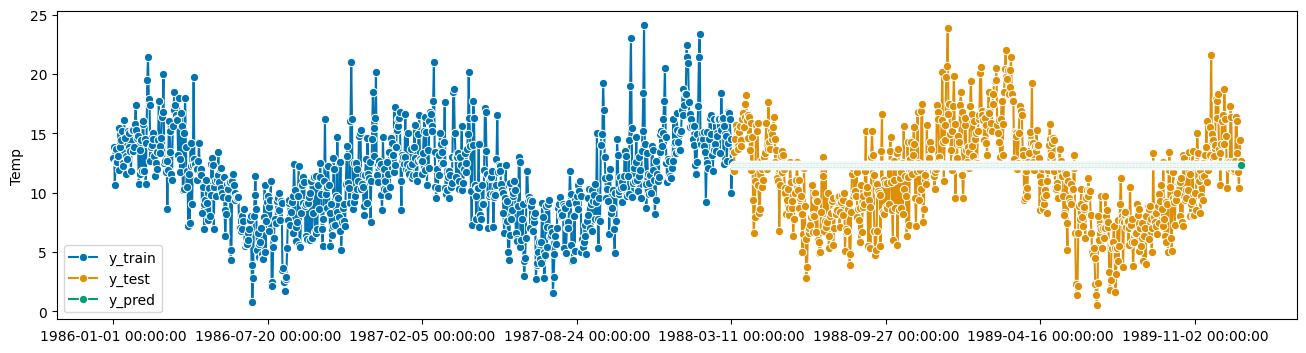

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


sMAPE = 0.251


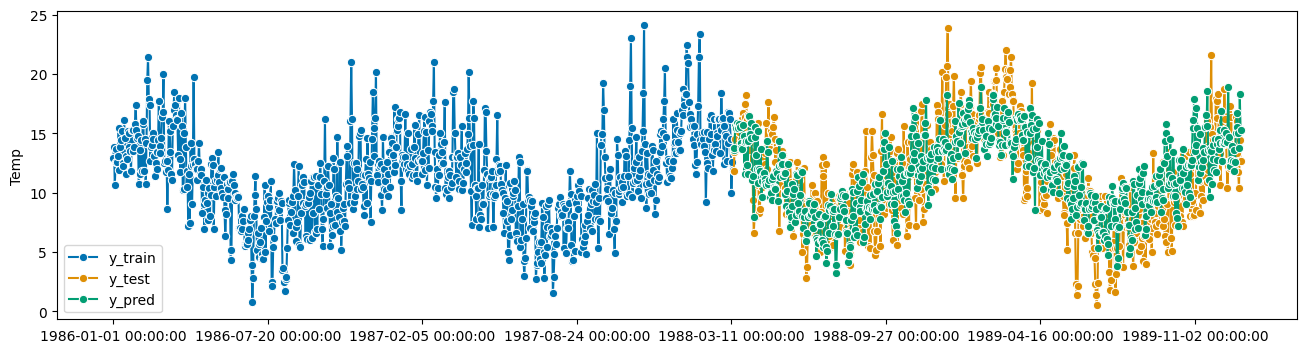

In [ ]:
SEASON = 365

# МЕТОДЫ
ses         = ExponentialSmoothing(sp=SEASON)
holt_1        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
holt_2        = ExponentialSmoothing(trend="additive", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)

holt_winter_add_boxcox_1  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_add_boxcox_2  = ExponentialSmoothing(trend="additive", seasonal="additive", use_boxcox =True, sp=SEASON)

holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)



forecaster = holt_winter_add_boxcox_2

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Используем ансамбль методов экспоненциального сглаживания

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


sMAPE = 0.306


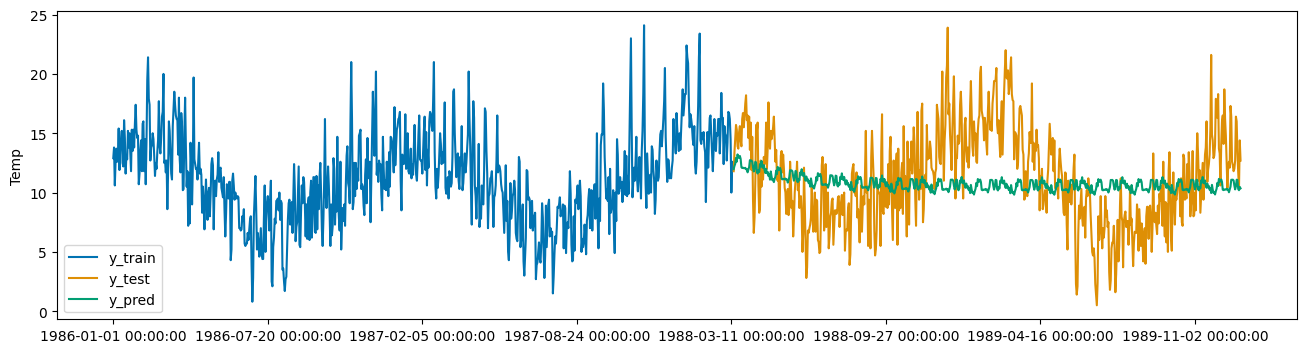

In [ ]:
from sktime.forecasting.compose import (
    EnsembleForecaster)
#     MultiplexForecaster,
#     TransformedTargetForecaster,
#     make_reduction,
# )

SEASON = 52

# МЕТОДЫ
ses         = ExponentialSmoothing(sp=SEASON)
holt        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)

# ПРЕДСКАЗАТЕЛЬ
forecaster = EnsembleForecaster(
    [
        ("ses", ses),
        # ("holt", holt),
        # ("damped", damped_holt),
        ("holt-winter", holt_winter),
        # ("holt-winter, additive trend, box-cox", holt_winter_add_boxcox),
        ("holt-winter, multiplicative trend, box-cox", holt_winter_mul_boxcox),
        # ("holt-winter, multiplicative season, box-cox", holt_winter_sadd_boxcox),
        # ("holt-winter, multiplicative both,   box-cox", holt_winter_smul_boxcox)
    ]
)
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], markers = [None, None, None])

# РЕЗУЛЬТАТ
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Декомпозиция временного ряда с использованием функции seasonal_decompose

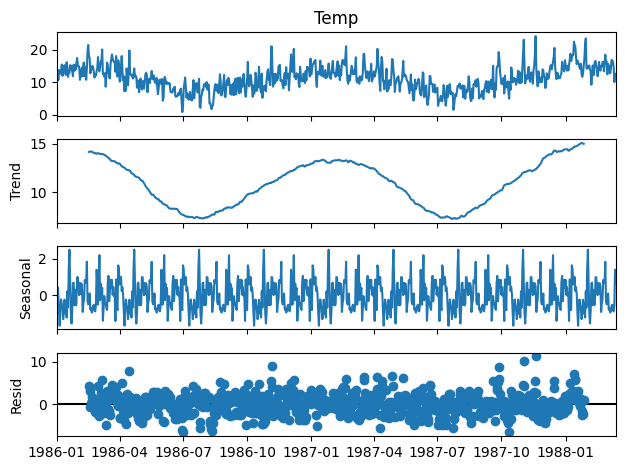

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y_train, model='additive', period = 93)
result.plot();

Построим график задержки для нашего фрагмента датасета

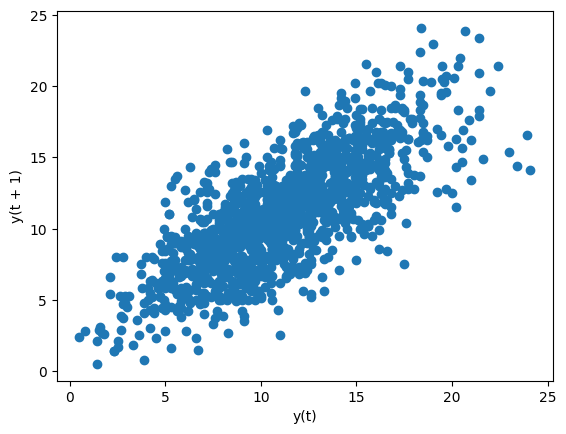

In [ ]:
from pandas import Series
from matplotlib import pyplot
from pandas.plotting import lag_plot
series = df_86_89
lag_plot(series, lag = 1)
pyplot.show()


In [ ]:
from pandas import Series
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
series = df_86_89
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.763691
t+1  0.763691  1.000000


Этот график показывает зависимость коэффициента корреляции от величины лага, мы рассматриваем датасет колебаний температоры, видно, что чем больший лаг мы мозьмём, тем меньше будет автокорреляция, а так как к текущему значению (например летней температуре) мы можем сопоставить зимнюю температору (выбрав соответствующий лаг), то есть моменты, когда коэффициент корреляции уходит в минус

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

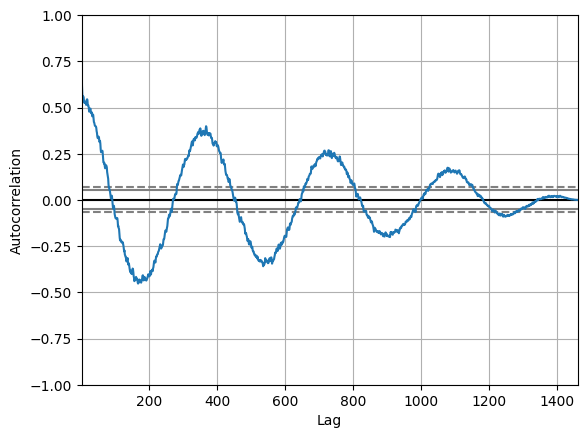

In [ ]:
#from pandas import Series
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
series = df_86_89
autocorrelation_plot(series)
#pyplot.show()

Также мы можем представить ту же зависимость в виде линейного графика

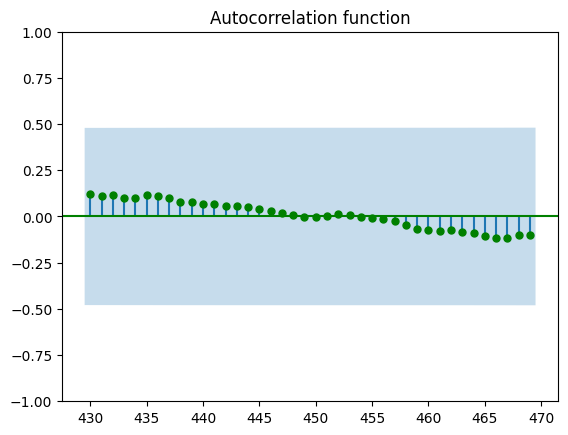

In [ ]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series = df_86_89
plot_acf(series, lags=(range(430, 470)), color='g', title='Autocorrelation function')
pyplot.show()